# Sample supervised segmentation on Gray images

apllying the segmentation pipe line with default parameters on samle images

In [1]:
%matplotlib inline
import os, sys, glob, time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import segmentation.utils.data_io as tl_data
import segmentation.pipelines as segm_pipe

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Load image

In [3]:
path_dir = tl_data.update_path(os.path.join('images', 'drosophila_ovary_slice'))
path_images = os.path.join(path_dir, 'image')
print ([os.path.basename(p) for p in glob.glob(os.path.join(path_images, '*.jpg'))])
path_img = os.path.join(path_images, 'insitu7545.jpg')
img = np.array(Image.open(path_img))[:, :, 0]
path_img = os.path.join(path_images, 'insitu7544.jpg')
img2 = np.array(Image.open(path_img))[:, :, 0]

path_annots = os.path.join(path_dir, 'annot_struct')
path_annot = os.path.join(path_annots, 'insitu7545.png')
annot = np.array(Image.open(path_annot))

['insitu4174.jpg', 'insitu4358.jpg', 'insitu7331.jpg', 'insitu7544.jpg', 'insitu7545.jpg']


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1658b4b668>,
 <matplotlib.image.AxesImage at 0x7f1658a733c8>)

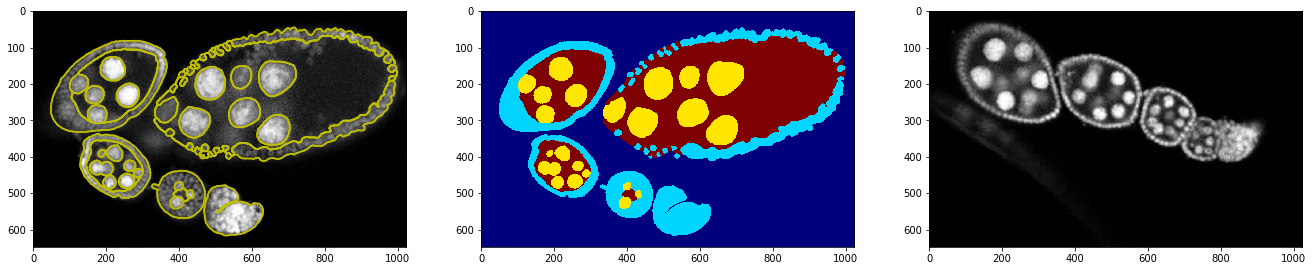

In [6]:
FIG_SIZE = (12. * np.array(img.shape[:2]) / np.max(img.shape))
fig = plt.figure(figsize=FIG_SIZE * 3)
plt.subplot(1,3,1), plt.imshow(img, cmap=plt.cm.Greys_r), plt.contour(annot, colors='y')
plt.subplot(1,3,2), plt.imshow(annot, cmap=plt.cm.jet)
plt.subplot(1,3,3), plt.imshow(img2, cmap=plt.cm.Greys_r)

## Segment Image

In [10]:
nb_classes = 3
clr_space = 'rgb'
sp_size = 25
sp_regul = 0.2
dict_features = {'color': ['mean', 'std', 'median'], 'tLM': ['mean']}

In [11]:
classif, list_slic, list_features, list_labels = segm_pipe.train_classif_color2d_slic_features([img], [annot], 
             clr_space, sp_size, sp_regul, dict_features=dict_features, pca_coef=None)

In [21]:
dict_debug = {}
seg = segm_pipe.segment_color2d_slic_features_classif_graphcut(img2, classif, clr_space, sp_size, sp_regul, 
                   gc_regul=1., dict_features=dict_features, gc_edge_type='model', dict_debug_imgs=dict_debug)

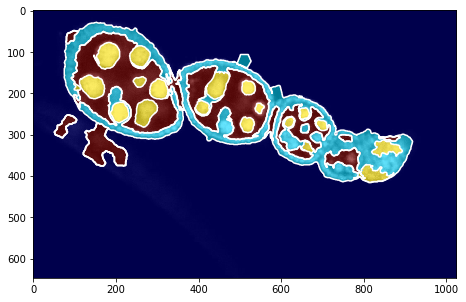

In [23]:
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(img2, cmap=plt.cm.Greys_r)
plt.imshow(seg, alpha=0.6, cmap=plt.cm.jet)
plt.contour(seg, levels=np.unique(seg), colors='w')

## Visualise

['imgs_unary_cost', 'slic', 'slic_mean', 'edge_weights', 'segments', 'img', 'edges', 'img_graph_edges', 'img_graph_segm']


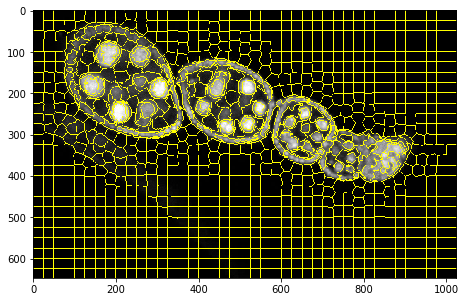

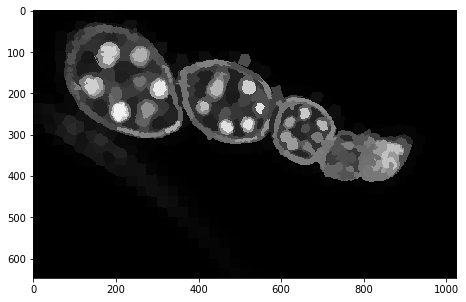

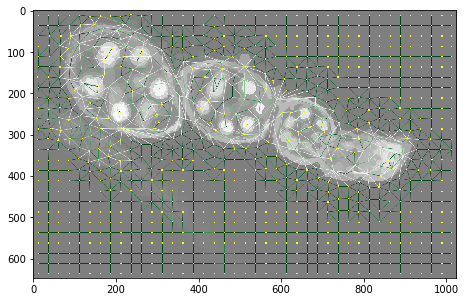

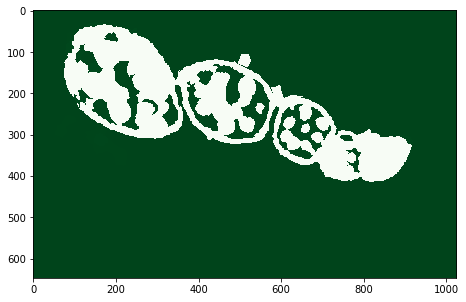

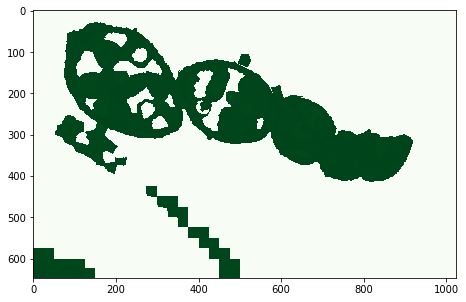

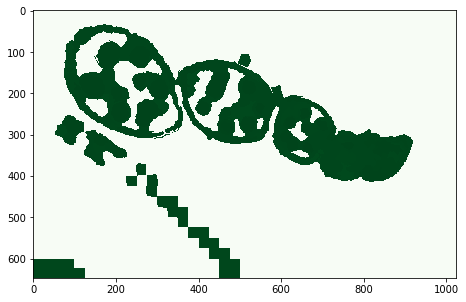

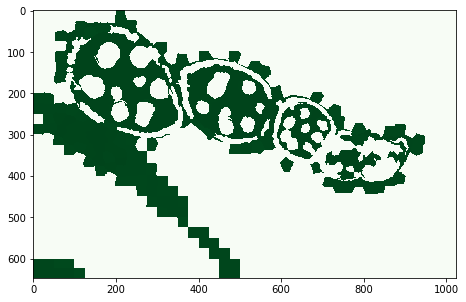

In [24]:
print ('debug fields:', dict_debug.keys())
_= plt.figure(figsize=FIG_SIZE), plt.imshow(mark_boundaries(img2, dict_debug['slic']))
_= plt.figure(figsize=FIG_SIZE), plt.imshow(dict_debug['slic_mean'])
_= plt.figure(figsize=FIG_SIZE), plt.imshow(dict_debug['img_graph_edges'])
for im_u in dict_debug['imgs_unary_cost']:
    _= plt.figure(figsize=FIG_SIZE), plt.imshow(im_u)
# plt.figure(), plt.imshow(dict_debug['img_graph_segm'])